In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import torch.nn as nn
import torch
import torchvision.models as models
from torchvision.models import ResNet18_Weights


# Download the following data set for the code to run:

- [Link](https://drive.google.com/drive/folders/0B7EVK8r0v71pWEZsZE9oNnFzTm8?resourcekey=0-5BR16BdXnb8hVj6CNHKzLg)
- After downloading, please make sure to include the zip file inside the directory of this notebook
    - Make sure the images are inside 2 subdirectories img_celeba/img_celeba



## Data exploration


In [2]:
# Define paths
base_dir = 'img_celeba'
bbox_excel_path = os.path.join(base_dir, 'list_bbox_celeba.txt')
identity_txt_path = os.path.join(base_dir, 'identity_CelebA.txt')
images_dir = os.path.join(base_dir, 'img_celeba')

# Read the Excel file for bounding boxes
bbox_df = pd.read_csv(bbox_excel_path, sep='\s+', skiprows=1)

# Read the identity file
identity_df = pd.read_csv(identity_txt_path, sep=" ", header=None, names=['image_id', 'identity'])
# Path to the evaluation partition file
eval_partition_path = os.path.join(base_dir, 'list_eval_partition.txt')

# Read the evaluation partition file
eval_partition_df = pd.read_csv(eval_partition_path, sep='\s+',
                                header=None, names=['image_id', 'evaluation_status'])

# Merge the evaluation partition data with the bounding boxes and identity data
merged_df = pd.merge(bbox_df, identity_df, on='image_id')
merged_df = pd.merge(merged_df, eval_partition_df, on='image_id')

# Split the merged data into training, validation, and testing datasets
train_df = merged_df[merged_df['evaluation_status'] == 0].drop(columns=['evaluation_status'])
val_df = merged_df[merged_df['evaluation_status'] == 1].drop(columns=['evaluation_status'])
test_df = merged_df[merged_df['evaluation_status'] == 2].drop(columns=['evaluation_status'])


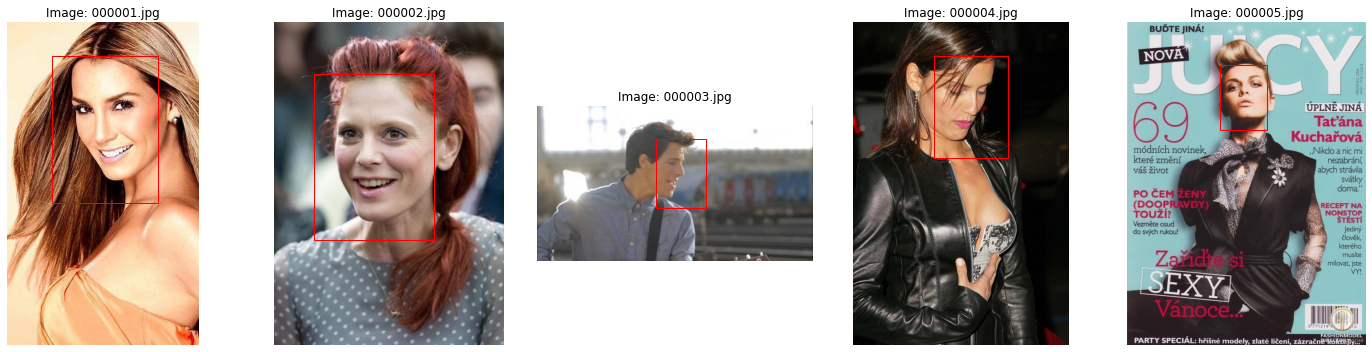

In [3]:
# Display first 5 images with bounding boxes and identity
fig, axs = plt.subplots(1, 5, figsize=(20, 5))
for i, row in merged_df.iterrows():
    if i >= 5:  # Only process the first 5 entries
        break
    img_path = os.path.join(images_dir, row['image_id'])
    img = Image.open(img_path)

    x = row['x_1']
    y = row['y_1']

    # Create a Rectangle patch
    rect = patches.Rectangle((x, y), row['width'], row['height'], linewidth=1, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    axs[i].imshow(img)
    axs[i].add_patch(rect)
    axs[i].set_title(f"Image: {row['image_id']}")
    axs[i].axis('off')

plt.tight_layout()
plt.show()

In [4]:
class CelebADataset(Dataset):
    def __init__(self, dataframe, images_dir, transform=None):
        self.dataframe = dataframe
        self.images_dir = images_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.images_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name)
        original_width, original_height = image.size

        bbox = self.dataframe.iloc[idx, 1:5].values.astype('float')
        identity = self.dataframe.iloc[idx, 5]

        if self.transform:
            image = self.transform(image)
            new_width, new_height = 128, 128
            # Calculate scale factors
            scale_width = new_width / original_width
            scale_height = new_height / original_height
            # Adjust bounding box. Format assumed to be [x, y, width, height]
            bbox[0] = bbox[0] * scale_width  # x
            bbox[1] = bbox[1] * scale_height  # y
            bbox[2] = bbox[2] * scale_width  # width
            bbox[3] = bbox[3] * scale_height  # height

        sample = {'image': image, 'bbox': bbox, 'identity': identity}

        return sample

In [5]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [6]:
# Create instances of the dataset
train_dataset = CelebADataset(dataframe=train_df, images_dir=images_dir, transform=transform)
val_dataset = CelebADataset(dataframe=val_df, images_dir=images_dir, transform=transform)
test_dataset = CelebADataset(dataframe=test_df, images_dir=images_dir, transform=transform)


In [7]:
def imshow_with_bbox(img, bbox):
    """Plot an image with a bounding box."""
    # Denormalize the image
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img.numpy().transpose((1, 2, 0))  # Convert from Tensor image
    img = std * img + mean  # Denormalize
    img = np.clip(img, 0, 1)  # Clip to [0, 1]

    # Create figure and axes
    fig, ax = plt.subplots(1)
    ax.imshow(img)

    # Create a Rectangle patch
    rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)
    plt.show()

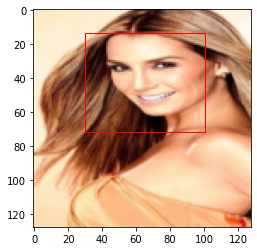

In [8]:
data = train_dataset[0]
img = data['image']
bbox = data['bbox']
imshow_with_bbox(img, bbox)

In [9]:
# Create data loaders
batch_size = 32  # You can adjust this size as per your computational resources

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
print("Finished Validation Loading")

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
print("Finished Test Loading")

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
print("Finished Train Loading")

Finished Validation Loading
Finished Test Loading
Finished Train Loading


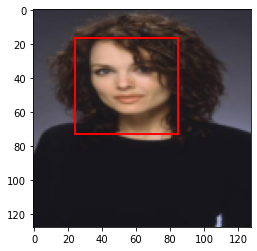

In [19]:

def imshow_with_bbox(img, bbox, ax=None):
    """Plot an image with a bounding box."""
    if ax is None:
        fig, ax = plt.subplots(1)

    # Denormalize the image if it's normalized
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img.permute(1, 2, 0).numpy()  # Convert from C,H,W to H,W,C for plotting
    img = std * img + mean  # Denormalize
    img = np.clip(img, 0, 1)  # Clip to ensure [0, 1] range

    ax.imshow(img)

    # Create a Rectangle patch for the bounding box
    # bbox format is assumed to be [x, y, width, height]
    rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.show()


# Load the first batch from the validation DataLoader
for batch in val_loader:
    images, bboxes, labels = batch['image'], batch['bbox'], batch['identity']
    # Take the first image and its bbox
    img, bbox = images[0], bboxes[0]
    imshow_with_bbox(img, bbox)
    break  # Only process the first batch


In [20]:
class MultiTaskCNN(nn.Module):
    def __init__(self, num_classes):
        super(MultiTaskCNN, self).__init__()
        # Load a pre-trained model as a feature extractor
        base_model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
        self.features = nn.Sequential(*list(base_model.children())[:-2])  # Exclude the last fc layer

        self.bbox_head = nn.Sequential(
            nn.AdaptiveAvgPool2d(output_size=(1, 1)),
            nn.Flatten(),
            nn.Linear(base_model.fc.in_features, 4)  # 4 outputs for bbox (x, y, width, height)
        )

        self.classifier_head = nn.Sequential(
            nn.AdaptiveAvgPool2d(output_size=(1, 1)),
            nn.Flatten(),
            nn.Linear(base_model.fc.in_features, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        bbox = self.bbox_head(x)
        class_logits = self.classifier_head(x)
        return bbox, class_logits


In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [22]:
num_classes = len(train_df['identity'].unique())
model = MultiTaskCNN(num_classes=num_classes)
model = model.to(device)

bbox_loss_fn = nn.MSELoss().to(device)
class_loss_fn = nn.CrossEntropyLoss().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [23]:
def evaluate_model(model, data_loader, criterion_bbox, criterion_class):
    model.eval()  # Set the model to evaluation mode
    total_bbox_loss = 0
    total_class_loss = 0

    with torch.no_grad():  # No need to track gradients for evaluation
        for images, bboxes, labels in data_loader:
            images = images.to(device)
            bboxes = bboxes.to(device)
            labels = labels.to(device)
            # Forward pass
            pred_bboxes, pred_labels = model(images)

            # Compute losses
            bbox_loss = criterion_bbox(pred_bboxes, bboxes)
            class_loss = criterion_class(pred_labels, labels)
            total_bbox_loss += bbox_loss.item()
            total_class_loss += class_loss.item()

    avg_bbox_loss = total_bbox_loss / len(data_loader)
    avg_class_loss = total_class_loss / len(data_loader)
    return avg_bbox_loss, avg_class_loss

In [24]:
print(len(train_dataset))  # This should print a positive number

162770


In [25]:
print(len(train_loader))  # This should also print a positive number, indicating batches

5087


In [29]:
num_epochs = 2
train_bbox_losses = []
train_class_losses = []
val_bbox_losses = []
val_class_losses = []

for epoch in range(num_epochs):
    print(f"epoch {epoch}")
    total_batches = len(train_loader)
    model.train()  # Set the model to training mode
    total_train_bbox_loss = 0
    total_train_class_loss = 0
    for batch in val_loader:
        images, bboxes, labels = batch['image'], batch['bbox'], batch['identity']
        images = images.to(device).float()  # Cast to float
        bboxes = bboxes.to(device).float()  # Cast to float
        labels = labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        pred_bboxes, pred_labels = model(images)

        # Compute losses
        bbox_loss = bbox_loss_fn(pred_bboxes, bboxes)
        class_loss = class_loss_fn(pred_labels, labels)
        total_loss = bbox_loss + class_loss

        # Backward pass and optimize
        total_loss.backward()
        optimizer.step()

        total_train_bbox_loss += bbox_loss.item()
        total_train_class_loss += class_loss.item()

    # Calculate average losses for the current epoch
    avg_train_bbox_loss = total_train_bbox_loss / len(train_loader)
    avg_train_class_loss = total_train_class_loss / len(train_loader)
    train_bbox_losses.append(avg_train_bbox_loss)
    train_class_losses.append(avg_train_class_loss)

    # Evaluate on the validation set
    avg_val_bbox_loss, avg_val_class_loss = evaluate_model(model, val_loader, bbox_loss_fn, class_loss_fn)
    val_bbox_losses.append(avg_val_bbox_loss)
    val_class_losses.append(avg_val_class_loss)

    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train BBox Loss: {avg_train_bbox_loss:.4f}, '
          f'Train Class Loss: {avg_train_class_loss:.4f}, '
          f'Val BBox Loss: {avg_val_bbox_loss:.4f}, '
          f'Val Class Loss: {avg_val_class_loss:.4f}')


epoch 0
Starting batch 1/5087
Starting batch 2/5087
Starting batch 3/5087
Starting batch 4/5087
Starting batch 5/5087
Starting batch 6/5087
Starting batch 7/5087
Starting batch 8/5087
Starting batch 9/5087
Starting batch 10/5087
Starting batch 11/5087
Starting batch 12/5087
Starting batch 13/5087
Starting batch 14/5087
Starting batch 15/5087
Starting batch 16/5087
Starting batch 17/5087
Starting batch 18/5087
Starting batch 19/5087
Starting batch 20/5087
Starting batch 21/5087
Starting batch 22/5087
Starting batch 23/5087
Starting batch 24/5087
Starting batch 25/5087
Starting batch 26/5087
Starting batch 27/5087
Starting batch 28/5087
Starting batch 29/5087
Starting batch 30/5087
Starting batch 31/5087
Starting batch 32/5087
Starting batch 33/5087
Starting batch 34/5087
Starting batch 35/5087
Starting batch 36/5087
Starting batch 37/5087
Starting batch 38/5087
Starting batch 39/5087
Starting batch 40/5087
Starting batch 41/5087
Starting batch 42/5087
Starting batch 43/5087
Starting bat

KeyboardInterrupt: 

In [ ]:

# Plotting the training and validation losses
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_bbox_losses, label='Train BBox Loss')
plt.plot(val_bbox_losses, label='Val BBox Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Bounding Box Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_class_losses, label='Train Class Loss')
plt.plot(val_class_losses, label='Val Class Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Classification Loss')
plt.legend()

plt.show()